In [32]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from ovejero import bnn_alexnet, model_trainer, data_tools

def NOTIMPLEMENTED():
    raise NotImplementedError('Must specify config path')

# Testing the Performance of a Model That Has Been Fit

__Author:__ Sebastian Wagner-Carena

__Created:__ 11/7/2019

__Last Run:__ 11/7/2019

__Goals:__ Learn how to test the performance of a trained model on the validation set.

__Before running this notebook:__ Run the Train_Toy_Model notebook to understand how to train a model. Then train a model with whatever configuration you want. You will have to add the path to the config file in this notebook.

In [79]:
# First specify the config path
config_path = '../configs/t1_local.json' #NOTIMPLEMENTED()

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)

# Get the model (ignore the loss function since we won't use it)
model, _ = model_trainer.model_loss_builder(cfg)

# Load the validation data we're going to use to test the performance of our model
tf_record_path_v = cfg['validation_params']['root_path']+cfg['validation_params']['tf_record_path']
final_params = cfg['training_params']['final_params']
batch_size = 128

In [80]:
tf_dataset_v = data_tools.build_tf_dataset(tf_record_path_v,final_params,batch_size,1)
for image_batch, output_batch in tf_dataset_v.take(1):
    image_batch = image_batch.numpy()
    output_batch = output_batch.numpy()

In [81]:
predict_batch = model.predict(image_batch)

In [82]:
predict_batch.shape

(128, 16)

[0.60268784 0.8474883  0.11213025 0.15761067 0.63636863 0.51904804
 0.35211074 0.2527049 ]


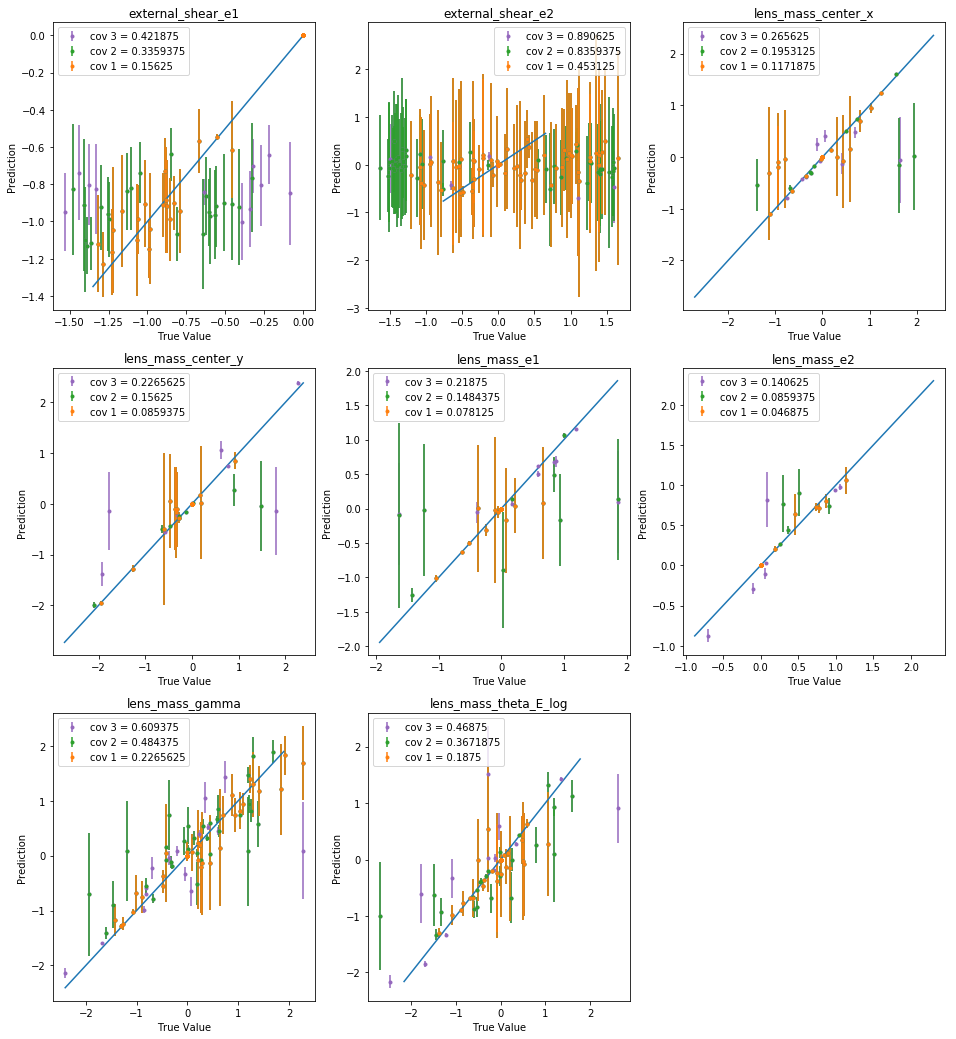

In [83]:
y_test = output_batch
y_param_pred = predict_batch[:,:num_params]
y_std = np.exp(predict_batch[:,num_params:])
    
plt.figure(figsize=(16,18))
sub_samp = list(range(len(y_test)))
error = y_param_pred - y_test
cov_mask_1 = np.abs(error) < y_std
cov_mask_2 = np.abs(error) < 2*y_std
cov_mask_3 = np.abs(error) < 3*y_std
coverage_1 = np.sum(cov_mask_1, axis=0) / batch_size
coverage_2 = np.sum(cov_mask_2, axis=0) / batch_size
coverage_3 = np.sum(cov_mask_3, axis=0) / batch_size   
for i in range(len(final_params)):
    plt.subplot(3, 3, i+1)
    plt.errorbar(y_test[sub_samp,i]*cov_mask_3[sub_samp,i], y_param_pred[sub_samp,i]*cov_mask_3[sub_samp,i],
                 yerr=y_std[sub_samp,i]*cov_mask_3[sub_samp,i], fmt='.', label='cov 3 = '+ str(coverage_3[i]),
                color='C4')
    plt.errorbar(y_test[sub_samp,i]*cov_mask_2[sub_samp,i],y_param_pred[sub_samp,i]*cov_mask_2[sub_samp,i],
                 yerr=y_std[sub_samp,i]*cov_mask_2[sub_samp,i], fmt='.', label='cov 2 = '+ str(coverage_2[i]),
                color='C2')
    plt.errorbar(y_test[sub_samp,i]*cov_mask_1[sub_samp,i],y_param_pred[sub_samp,i]*cov_mask_1[sub_samp,i],
                 yerr=y_std[sub_samp,i]*cov_mask_1[sub_samp,i], fmt='.', label='cov 1 = '+ str(coverage_1[i]),
                color='C1')
    # plot confidence interval
    straight = np.linspace(np.min(y_param_pred[:,i]), np.max(y_param_pred[:,i]), 1000)
    plt.plot(straight, straight, label='',color='C0')
    plt.title(final_params[i])
    plt.ylabel('Prediction')
    plt.xlabel('True Value')
    plt.legend()
print(np.median(np.abs(y_param_pred-y_test),axis=0))
plt.show()